<a href="https://colab.research.google.com/github/rturquier/depythons/blob/main/Rendu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Projet informatique - Python pour le data scientist
##### Jérémie Stym-Popper, Luca Teodorescu, Rémi Turquier
# Peut-on prédire l'appartenance politique selon le discours des députés ?


Ce projet consiste à effectuer du *Natural Language Processing* sur le discours que tiennent les députés parlementaires.

L'objectif principal consiste à entraîner un ou plusieurs modèles sur les députés appartenant à des partis étant traditionnellement reconnus de gauche (PS, LFI) et de droite (LR), puis essayer de prédire cette classfication sur le parti LREM qui se situe entre les deux bords.

Nous avons prélevé les textes depuis deux sources : une première manière a consister en utilisant les interventions des députés à l'Assemblée (nous avons utilisé l'API venant du site [nosdeputes.fr](https://www.nosdeputes.fr/), puis scrappé les discours d'un député ciblé. Nous avons également scrappé Twitter pour retrouver les tweets des députés et diversifier ainsi nos sources.

Dans ce Notebook, nous utilisons à plusieurs reprises des modules que nous avons codés par ailleurs et déposés sur Github. Ces modules utilisent des packages comme **wordcloud**, **unidecode**, **warnings** et **fuzzywuzzy** qu'il faudrait préalablement installer pour pouvoir tout lire.

In [1]:
# Imports
from urllib import request

import numpy as np
import pandas as pd
import spacy

import collections
import re
import matplotlib.pyplot as plt

In [2]:
# Si les imports de la cellule suivante ne fonctionnent pas,
# on peut exécuter ces lignes :

# import sys
# directory = r"path/to/repo"
# sys.path.append(directory)

In [3]:
from depute_api import CPCApi

## Récupération des données
Les données ont été récupérées par l'intermédiaire de [l'API](https://github.com/regardscitoyens/nosdeputes.fr/blob/master/doc/api.md) mise à disposition par l'association Regards citoyens.

Nous avons d'abord utilisé un module nommé depute_api, que nous avons ensuite complété avec deux fonctions :
Les fonctions *interventions* et *interventions2* permettent d'entrer le nom d'un député pour obtenir une liste d'interventions (sous forme de liste de str).

Ensuite, nous avons créé plusieurs DataFrames à l'aide de la fonction interventions 2, avec les fonctions suivantes :

In [5]:
from get_dep_remi import stockintervention

Voici un exemple d'utilisation. Pour éviter de perdre du temps ici (la fonction peut mettre du temps à s'exécuter sur les échantillons de grande taille), on exécute la fonction sur un petit parti politique.

In [6]:
api = CPCApi()
deputies_json = api.parlementaires()
deputies_df = pd.json_normalize(deputies_json)

UAI_df = stockintervention("UAI")
UAI_df

4
76           Yves Jégo
80      Franck Riester
289      Maurice Leroy
515    Napole Polutele
Name: nom, dtype: object
Yves Jégo
Franck Riester
Maurice Leroy
Napole Polutele


,groupe,nom,interventions
0,UAI,Yves Jégo,"[Yves Jégo Prochaine séance, ce soir, à vingt..."
1,UAI,Franck Riester,"[ Vous pouvez compter sur le groupe UDI, Agir ..."
2,UAI,Maurice Leroy,[Maurice Leroy – Nous avons examiné la PPE en...
3,UAI,Napole Polutele,"[ Oui, madame la présidente. , Madame la mini..."


## Nettoyage des données
Après une exploration préliminaire, nous avons choisi de nous concentrer sur trois groupes parlementaires.
Nous avons sélectionné les interventions des groupes LFI (La France Insoumise) et SOC (Socialistes) pour la gauche, et le groupe LR (Les Républicains) pour la droite.
### Création de la variable cible et mise en forme *tidy*

In [7]:
### Import des données brutes récupérées avec l'API
data_url = (
    "https://raw.githubusercontent.com/rturquier/depythons/main/Stock_csv/gd2_inter.csv"
)
df_brut = pd.read_csv(data_url)
df_brut.sample(n=5)

,groupe,nom,interventions
130,LR,Philippe Benassaya,"["" Non, mais je voudrais remercier monsieur le..."
162,SOC,Sylvie Tolmont,"["" Monsieur le ministre, toute la lumière doit..."
75,LR,Emmanuel Maquet,"["" Je propose moi aussi de supprimer l'article..."
119,LR,Robert Therry,"["" Bien entendu, le Gouvernement a mis en plac..."
90,LR,Vincent Rolland,"[' Eh oui ! ', ' Tout à fait ! ', ' Il y en a ..."


In [8]:
# Création d'une indicatrice `droite` qui sera la cible de la classification
df_brut = df_brut.assign(droite=df_brut["groupe"] == "LR")

In [9]:
# Régler un problème de type
from ast import literal_eval


def convert_to_list(interventions):
    return literal_eval(str(interventions))


df_brut["interventions"] = df_brut["interventions"].apply(convert_to_list)

In [10]:
# Séparer toutes les interventions en colonnes différentes
df_tidy = df_brut.explode("interventions")
df_tidy

,groupe,nom,interventions,droite
0,LFI,Jean-Luc Mélenchon,Ça c'est très juste ! Et ça méritait d'être d...,False
0,LFI,Jean-Luc Mélenchon,Vous avez à juste titre fait apercevoir à nos...,False
0,LFI,Jean-Luc Mélenchon,… – il n'est pas possible de compter sur une ...,False
0,LFI,Jean-Luc Mélenchon,Je voudrais féliciter notre collègue M'jid El...,False
0,LFI,Jean-Luc Mélenchon,Très bien !,False
...,...,...,...,...
167,SOC,Isabelle Santiago,Il vise également à supprimer l'alinéa 16. Le...,False
167,SOC,Isabelle Santiago,"Monsieur le Premier ministre, conséquence dir...",False
167,SOC,Isabelle Santiago,Le présent amendement propose de supprimer l'...,False
167,SOC,Isabelle Santiago,Il vise à instaurer un prélèvement sur les re...,False


In [11]:
# -- Équilibrage du nombre de d'interventions --
# Nous nous sommes posé la question de l'équilibrage des données.
# Après avoir envisagé plusieurs méthodes, nous avons choisi d'équilibrer les
# donées à la main. Ce n'est pas forcément la meilleure méthode, mais c'est
# sans doute la plus simple.
def n_droite_n_gauche(df):
    count = df.droite.value_counts()
    return count[True], count[False]


def balance_left_right(df):
    n_droite, n_gauche = n_droite_n_gauche(df)
    df = df.sort_values(by=["droite"], ascending=False)

    if n_droite > n_gauche:
        df = df[n_droite - n_gauche :]
    elif n_droite < n_gauche:
        df = df[2 * n_droite :]

    return df


df_tidy = balance_left_right(df_tidy)
n_droite_n_gauche(df_tidy)

(2454, 2454)

Le nombre d'interventions est bien équilibré.

### Longueur des interventions et regroupement par groupes de 5 interventions

In [12]:
# Création d'une variable qui contient la longueur des interventions
df_tidy = df_tidy.assign(longueur=df_tidy["interventions"].str.len())

In [13]:
# Regroupement par groupes de 5 interventions
# Pour cela, on crée une variable `numero_paquet_de_5` qui prend la même valeur
# pour 5 députés du même bord.
n_droite, n_gauche = n_droite_n_gauche(df_tidy)

df_tidy = df_tidy.sort_values(by=["droite"], ascending=False)
df_tidy["numero_paquet_de_5"] = list(range(n_droite)) + list(range(n_gauche))
df_tidy["numero_paquet_de_5"] = np.floor(df_tidy["numero_paquet_de_5"] / 5)
df_tidy["numero_paquet_de_5"] = df_tidy["numero_paquet_de_5"].astype(int)

In [14]:
# Grouper par bord politique et par numéro de paquet de 5, puis aggréger
df_collapsed = (
    df_tidy.drop(columns=["groupe", "nom"])
    .groupby(["droite", "numero_paquet_de_5"])
    .agg({"interventions": "".join, "longueur": ["min", "max", "mean"]})
    .reset_index()
)

# Arranger le nom des colonnes
df_collapsed.columns = [
    "_".join(col).rstrip("_") for col in df_collapsed.columns.values
]

df_collapsed = df_collapsed.drop(columns="numero_paquet_de_5").rename(
    columns={"interventions_join": "interventions"}
)

df_collapsed

,droite,interventions,longueur_min,longueur_max,longueur_mean
0,False,"Très bien, monsieur Peu ! L'IGPN ! … – il n...",10,660,271.60
1,False,Très bien ! Il est odieux ! Alerte ! Alerte...,13,667,254.40
2,False,C'est elle qui vous dicte ce qu'il faudrait f...,466,656,555.20
3,False,C'était leur droit ! Mme Cariou a tout de mê...,14,52,32.80
4,False,Je crois qu'ici tout le monde tâche de faire ...,10,481,116.60
...,...,...,...,...,...
977,True,Très juste ! Mais cela se passe dans un hôpi...,14,631,279.40
978,True,"Monsieur le Premier ministre, vous avez annon...",86,672,395.40
979,True,Le Conseil constitutionnel se place donc sur ...,34,656,346.80
980,True,Le Gouvernement défendait une position plus p...,230,662,489.40


Il reste à traiter le texte. On applique les transformations vues dans le dernier TD : mettre en minuscule, séparer tous les mots (tokenisation), supprimer les mots courants (stopwords), et ramener à la racine grammticale (lemmatisation).

In [15]:
# Mise en minuscules
df_spacy = df_collapsed.assign(interventions=df_collapsed.interventions.str.lower())

In [16]:
# Tokenisation
# Commande pour télécharger les données pour la version française de spaCy :
# python -m spacy download fr_core_news_sm
sp = spacy.load("fr_core_news_sm")
df_spacy["interventions"] = df_spacy.interventions.apply(lambda x: sp(x))

In [17]:
# Lemmatisation
df_spacy["interventions"] = df_spacy.interventions.apply(
    lambda tokens: [token.lemma_ for token in tokens]
)

# Copie du dataframe, utilisée dans la partie analyse descriptive
df_zipf = df_spacy.copy()

In [18]:
# Stopwords
stop_words = sp.Defaults.stop_words | {"'", ",", ";", ":", " ", "", "."}

df_spacy["interventions"] = df_spacy.interventions.apply(
    lambda words: [word for word in words if not word in stop_words]
)

In [19]:
# Résultat
print(
    str(df_collapsed.interventions[42]) + "\n ---> \n" + str(df_spacy.interventions[42])
)

 La science est pourtant claire : il nous reste une infime chance de ne pas dépasser le seuil de 1,5 degré Celsius de réchauffement climatique, mais à la condition de ne pas exploiter de nouveaux gisements de pétrole, de ne pas réaliser la totalité des 4,9 milliards de dollars d'investissements déjà prévus, de ne pas mettre en route l'ensemble des projets d'infrastructures énergétiques liés aux énergies fossiles, et j'en passe. Il est urgent d'agir dès à présent pour en finir avec ces énergies qui mettent en péril l'avenir de l'humanité.  Le groupe La France insoumise demande l'arrêt des garanties publiques à l'export dans le secteur des hydrocarbures, et il n'est pas le seul : des ONG comme Les Amis de la terre ou Oxfam réclament exactement la même chose. La fin des garanties publiques à l'export du charbon remonte déjà au précédent quinquennat et s'applique depuis 2016. Il convient désormais d'aller plus loin, dès ce projet de loi de finances pour 2021. Nous demandons donc l'interdic

Maintenant que le traitement préparatoire des données est terminé, nous
pouvons passer aux parties exploration et modélisation. Pour éviter toute
fuite d'information des données de test vers les données d'entrainement,
nous faisons dès maintenant la séparation. Nous avons retenu la proportion
*train* / *test* usuelle de 80% / 20%.


In [20]:
from sklearn.model_selection import train_test_split

X = df_spacy.drop("droite", axis=1)
y = df_spacy["droite"]

# L'argument `random_state` permet d'obtenir des résultats reproductibles.
split_list = train_test_split(
     X, y, test_size=0.2, random_state=42
)

# Réindexer maintenant pour éviter des soucis au moment du tf-idf
X_train, X_test, y_train, y_test = [
    df.reset_index().drop(columns = ["index"]) for df in split_list
]

# Analyse descriptive des données (Visualisation)

Nous allons maintenant dans cette partie visualiser les tendances dans les différents partis, ainsi que les mots qui sont les plus utilisés. Nous commençons par la loi Zipf, en regardant quels mots sont les plus employés par les partis de droite et de gauche.

On essaye de faire une analyse des fréquences des mots selon le catégorie droite/gauche et vérifier une potentielle loi de Zipf
Dans un premier temps sans enlever les stopwords



In [28]:
# On sépare en deux dataframe une pour chaque catégorie et on fait de même avec la dataframe spacy travaillée juste avant
df_zipf_droite = df_zipf[df_zipf["droite"]]
df_zipf_gauche = df_zipf[df_zipf["droite"] != True]
df_spacy_droite = df_spacy[df_spacy["droite"]]
df_spacy_gauche = df_spacy[df_spacy["droite"] != True]

In [29]:
# Dictionnaries de wordcount
wordcount_droite = collections.defaultdict(int)
wordcount_gauche = collections.defaultdict(int)
for inters in df_zipf_droite["interventions"]:
    for word in inters:
        wordcount_droite[word] += 1
for inters in df_zipf_gauche["interventions"]:
    for word in inters:
        wordcount_gauche[word] += 1

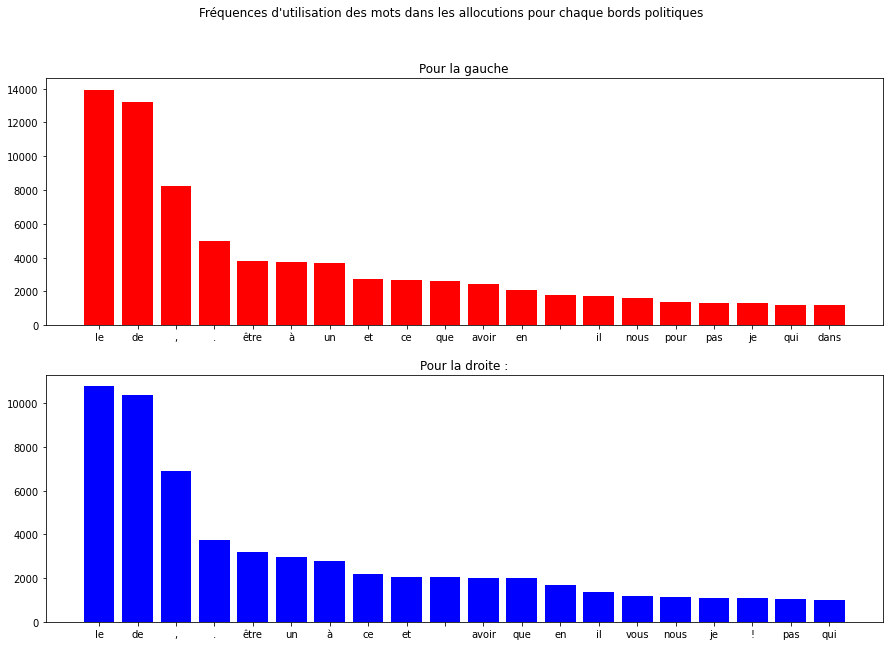

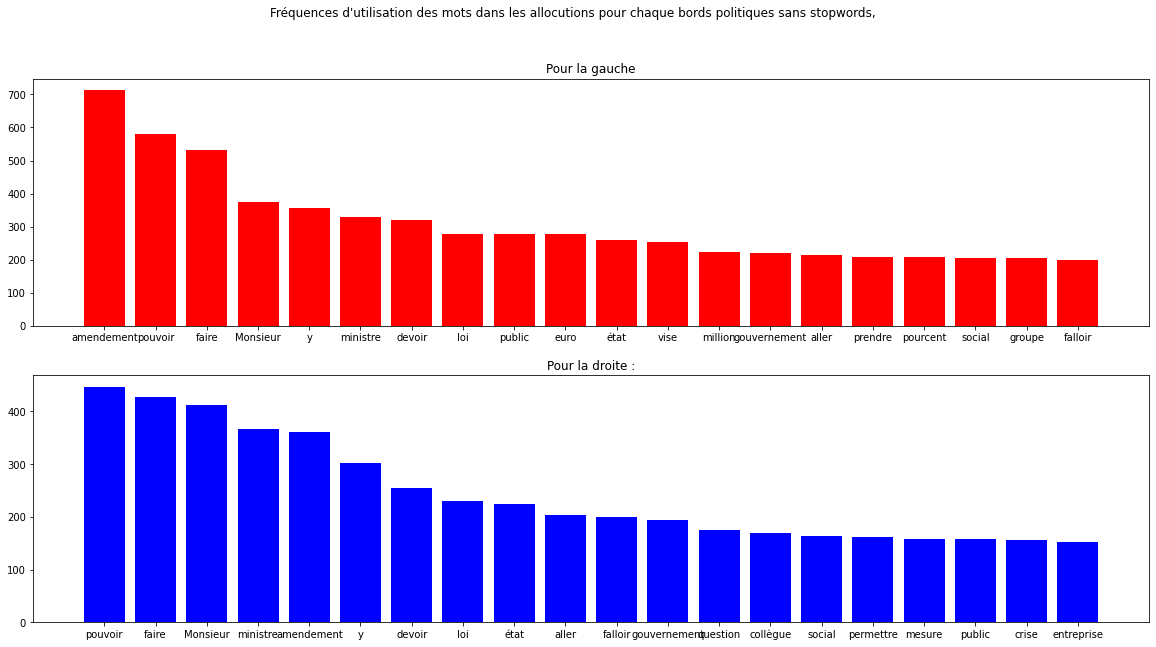

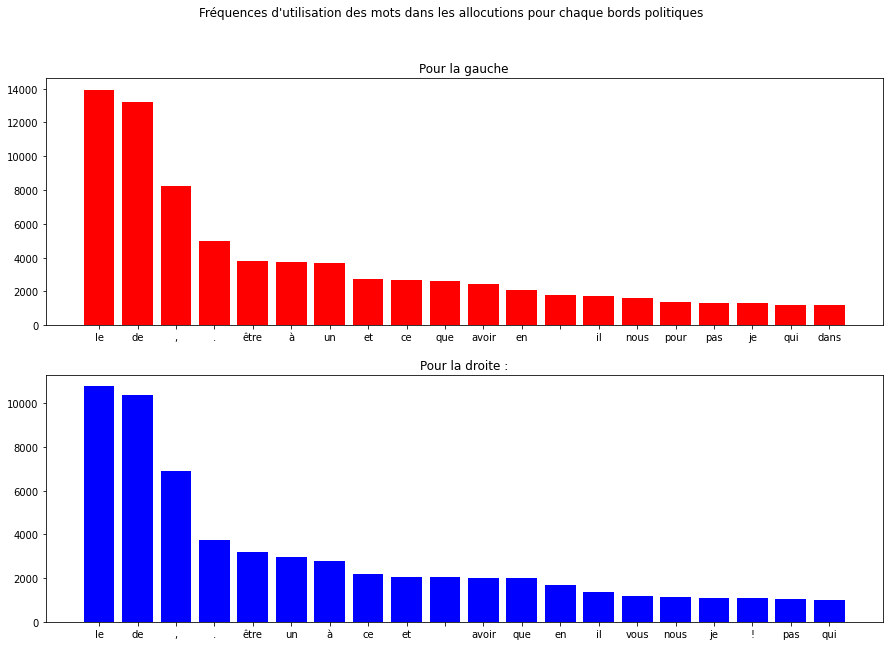

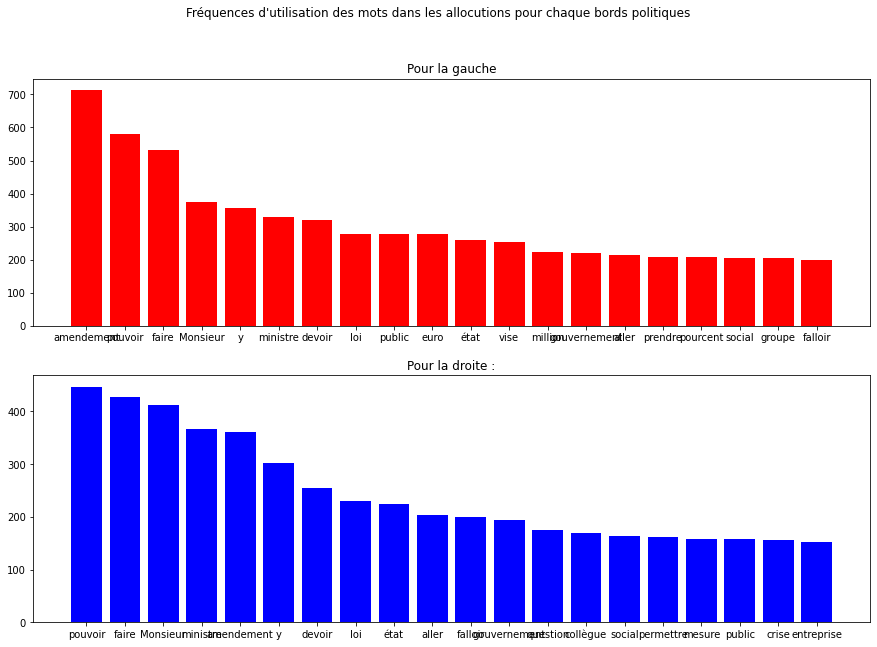

In [32]:
# On va afficher les 20 mots les plus populaires pour la gauche et la droite en comptant tous les mots
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle("Fréquences d'utilisation des mots dans les allocutions pour chaque bords politiques")
mcg = sorted(wordcount_gauche.items(), key=lambda k_v: k_v[1], reverse=True)[:20]
mcg = dict(mcg)
namesg = list(mcg.keys())
valuesg = list(mcg.values())
axs[0].bar(range(len(mcg)),valuesg,tick_label=namesg, color='red')
axs[0].set_title('Pour la gauche')
mcd = sorted(wordcount_droite.items(), key=lambda k_v: k_v[1], reverse=True)[:20]
mcd = dict(mcd)
namesd = list(mcd.keys())
valuesd = list(mcd.values())
axs[1].bar(range(len(mcd)),valuesd,tick_label=namesd, color='blue')
axs[1].set_title('Pour la droite :')
plt.show()

In [31]:
# On va maintenant voir le résultat avec une liste de stopwords
wordcount_droite = collections.defaultdict(int)
wordcount_gauche = collections.defaultdict(int)
for inters in df_spacy_droite["interventions"]:
    for word in inters:
        word = re.sub(r"\W", "", word)
        if word not in stop_words:
            wordcount_droite[word] += 1
for inters in df_spacy_gauche["interventions"]:
    for word in inters:
        word = re.sub(r"\W", "", word)
        if word not in stop_words:
            wordcount_gauche[word] += 1



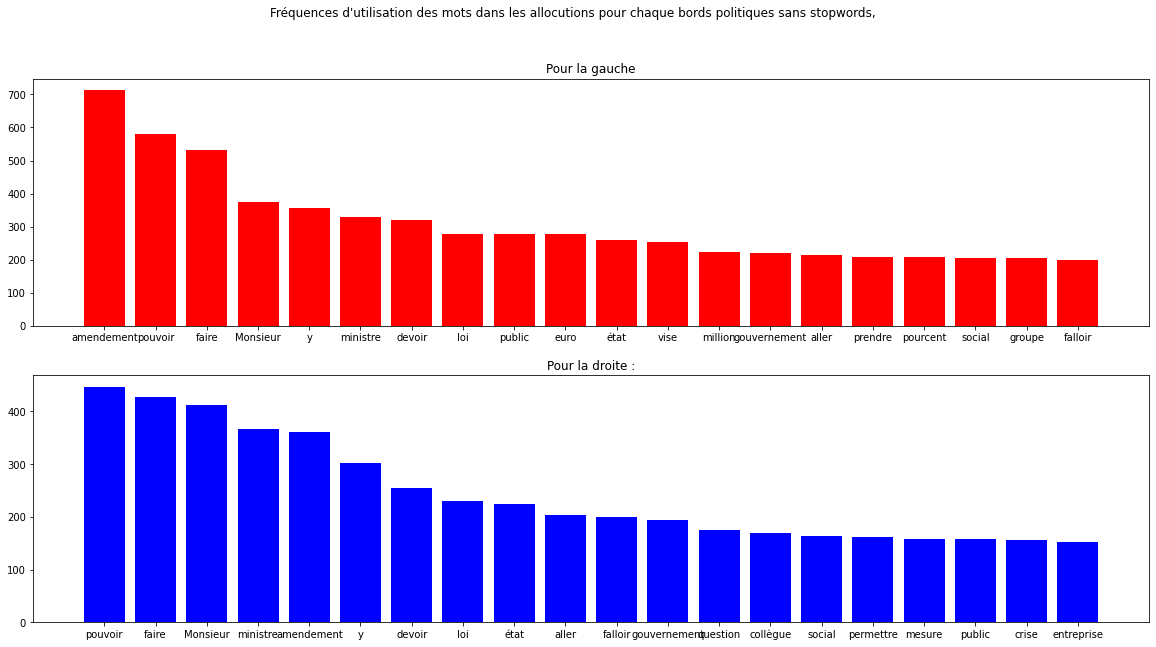

In [33]:
# On va afficher les 10 mots les plus populaires pour la gauche et la droite
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle("Fréquences d'utilisation des mots dans les allocutions pour chaque bords politiques sans stopwords,")
mcg = sorted(wordcount_gauche.items(), key=lambda k_v: k_v[1], reverse=True)[:20]
mcg = dict(mcg)
namesg = list(mcg.keys())
valuesg = list(mcg.values())
axs[0].bar(range(len(mcg)),valuesg,tick_label=namesg, color='red')
axs[0].set_title('Pour la gauche')
mcd = sorted(wordcount_droite.items(), key=lambda k_v: k_v[1], reverse=True)[:20]
mcd = dict(mcd)
namesd = list(mcd.keys())
valuesd = list(mcd.values())
axs[1].bar(range(len(mcd)),valuesd,tick_label=namesd, color='blue')
axs[1].set_title('Pour la droite :')
plt.show()

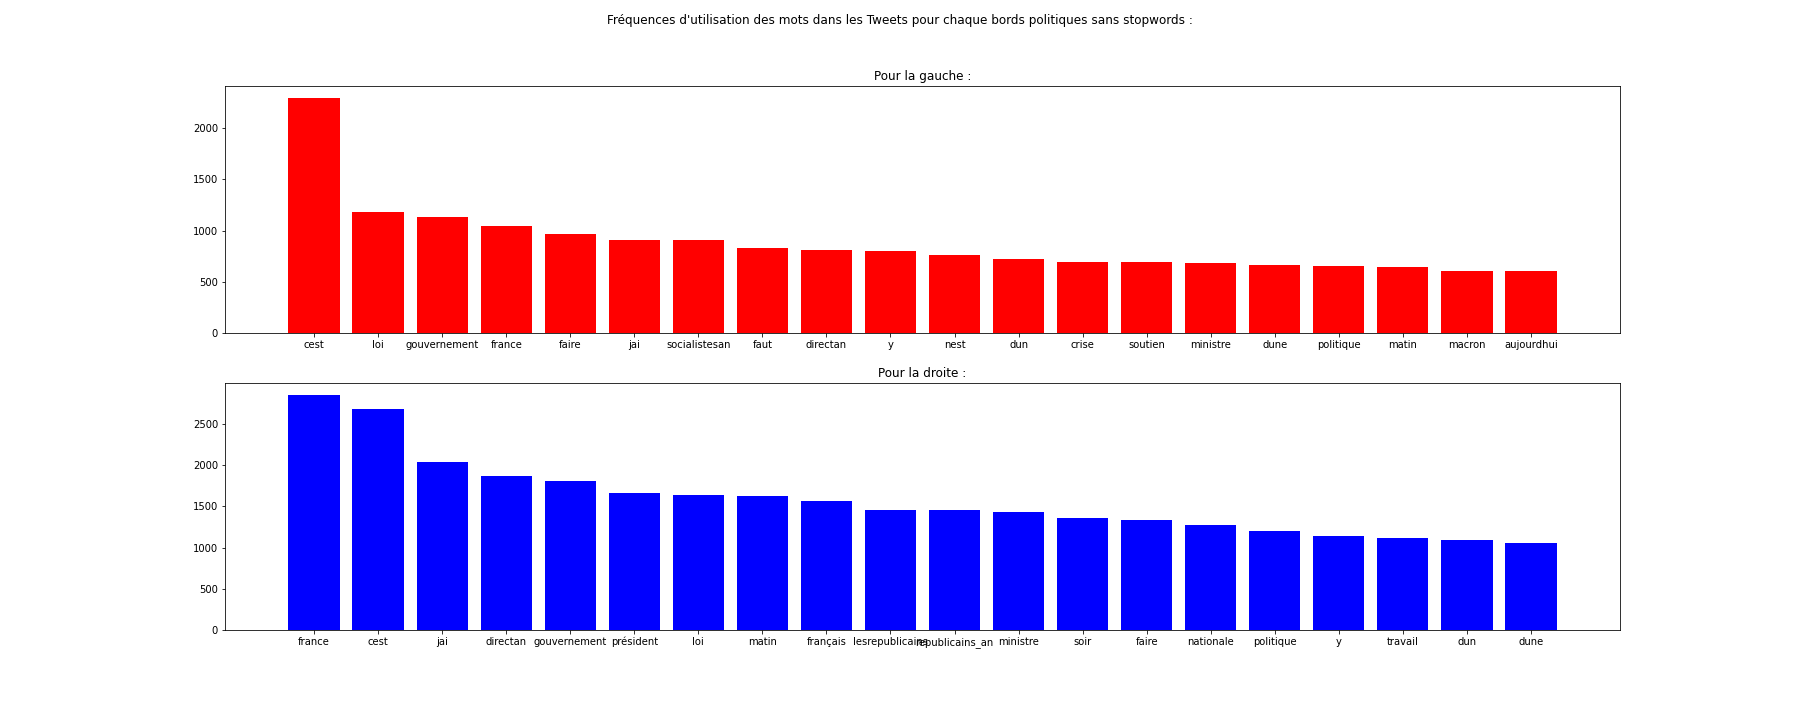

In [34]:
# On a fait le même travail dans visualisation_twitter.py sur une base de donnée twitter scrappé avec notre fichier twitter.py à titre de comparaison
from IPython.display import Image
Image(filename='Tweets_Frequence.png')

## Analyse descriptive des données

Nous allons maintenant visualiser les mots les plus utilisés de manière plus intuitive. À l'aide du module **wordcloud**, il est possible de visualiser quels sont les mots les plus utilisés par un député.

In [35]:
# Création d'un stopwords à partir d'un fichier txt. téléchargé et complété.

stopping_list = request.urlopen(
    "https://raw.githubusercontent.com/rturquier/depythons/main/stopwords-fr.txt"
).read()
stopping_list = stopping_list.decode("utf-8")
stopwords_list = stopping_list.split("\n")

In [36]:
from wordcloud_depython import wordcloud_gen

Quelques petits essais...

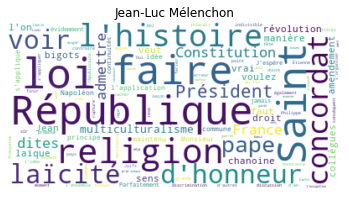

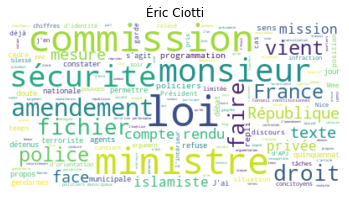

(None, None)

In [37]:
wordcloud_gen("Jean-Luc Mélenchon"), wordcloud_gen("Eric Ciotti")

# Modélisation

Nous passons maintenant à la partie modélisation. Pour cela, nous utilisons
les données que nous avons manipulées jusqu'ici. Nous commençons d'abord par
du **Features Engineering** en créant une matrice *TF-IDF* pour entraîner
les modèles.

Les deux modèles que nous avons choisis sont **Random Forest Classifier** et
**SVC**. Ils vont nous permettre de comparer les résultats et les scores
obtenus.

À chaque fois, nous nous effectuons une **validation croisée** pour déterminer
quels sont les meilleurs hyperparamètres, avant d'entaîner les modèles.

Enfin, nous finissons par utiliser les modèles pour prédire à quel bord
politique appartiennent les députés LREM.

In [38]:
# Voici tous les imports qui sont nécessaires pour cette partie et la suite

import collections

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report





/Applications/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**Définition du Tfidf**
Tfidf est une manière de transformer un corpus de texte en features. Chaque
mot a d'autant plus de poids qu'il est relativement fréquent dans un paquet
de 5 interventions par rapport aux autres paquet. Par exemple, un mot qui
apparait souvent, mais dans uniformément n'a pas beaucoup d'importance.

Comme la partie IDF (*Inverse Document Frequence*) utilise de l'information
de tout le corpus, il était important de séparer les données d'entrainement
des données de test avant d'appliquer tf-idf, dans cette [question StackOverflow](https://stackoverflow.com/questions/47778403/computing-tf-idf-on-the-whole-dataset-or-only-on-training-data).

Nous nous sommes rendu compte qu'utiliser *tous* les mots des interventions
(hormis les *stopwords*) conduisait à un sur-apprentissage. Cela est du au
fait que nous avons un nombre de données inférieur au nombre potentiel de
features créées par tf-idf.

Nous avons testé deux façons de limiter le nombre de features :
1. créer une liste de mots limitée à la main, et utiliser l'argument `vocabulary` de `TfidfVectorizer`
2. utiliser le paramètre `max_features`

Le code qui a servi à la première approche se trouve dans le fichier
`custom_words.py`. Nous avons finalement retenu la seconde approche, qui
tire meilleur parti des outils de NLP.


In [40]:
# On crée d'abord une fonction vide, qui permet de dire au `TfidfVectorizer`
# que nous avons déjà pré-traité le texte.

def dummy_fun(doc):
    return doc

tf_idf = TfidfVectorizer(
    analyzer = 'word',
    tokenizer = dummy_fun,
    preprocessor = dummy_fun,
    token_pattern = None,
    # vocabulary = super_liste
    max_features = 150
)

In [41]:
# Création des features avec tf-idf
X_train_tf_idf = tf_idf.fit_transform(X_train["interventions"])

# Quelques features retenues :
tf_idf.get_feature_names()[::10]

['!',
 'agir',
 'budget',
 'concerner',
 'droit',
 'faire',
 'grand',
 'mesure',
 'national',
 'petit',
 'projet',
 'rapport',
 'sens',
 'temps',
 'vouloir']

In [42]:
# Ajout des features tf_idf à la longueur des interventions
X_train_tf_idf = pd.DataFrame.sparse.from_spmatrix(X_train_tf_idf)
X_train = (X_train.merge(X_train_tf_idf, left_index = True, right_index = True)
            .drop(columns = ["interventions"])
)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

#### Troisième étape
Nous allons maintenant évaluer quels sont les meilleurs hyperparamètres pour chaque modèle.
* D'abord le modèle RandomForestClassifier
* Ensuite le modèle SVC

In [43]:
### Validation croisée pour le RandomForestClassifier
param_grid_rfc = {
    "n_estimators": [200, 500],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"],
}

CV_rfc = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid_rfc,
    cv=5
)


CV_rfc.fit(X_train, y_train)
opti_param_rfc = CV_rfc.best_params_

# La fonction met du temps à s'exécuter. Voici les paramètres qu'elle trouve :
# {'criterion': 'gini',
#  'max_depth': 6,
#  'max_features': 'sqrt',
#  'n_estimators': 200}
# Pas la peine de la relancer à chaque fois.

KeyboardInterrupt: 

In [ ]:
## Validation croisée pour trouver les hyperparamètres pour le modèle SVC

param_grid_svc = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]


CV_svc = GridSearchCV(estimator=SVC(), param_grid=param_grid_svc, cv=5)

CV_svc.fit(X_train, y_train)
opti_param_svc = CV_svc.best_params_
print("Les meilleurs hyperparamètres sont " + str(opti_param_svc))

Pour le modèle SVC, on trouve les hyperparamètres suivants :
`criterion="gini", max_depth=6, max_features="sqrt", n_estimators=200`

Nous allons maintenant entraîner les deux modèles successivment.

In [44]:
# Entrainement de la forêt aléatoire
clf = RandomForestClassifier(
    criterion="gini", max_depth=6, max_features="sqrt", n_estimators=200
)
clf.fit(X_train, y_train)

# Entrainement de la machine à vecteur de support (SVC)
svc = SVC(C=1000, gamma = 0.0001, kernel="rbf")
svc.fit(X_train, y_train)

SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Avant de pouvoir évaluer l'erreur de généralisation, il faut appliquer
quelques transformations aux données de test.
Ici, on applique uniquement la méthode `transform` des Transformers, la
méthode `fit` étant réservée à l'étape d'entrainement.

In [45]:
# tf-idf
X_test_tf_idf = tf_idf.transform(X_test["interventions"])

X_test_tf_idf = pd.DataFrame.sparse.from_spmatrix(X_test_tf_idf)
X_test = (X_test.merge(X_test_tf_idf, left_index = True, right_index = True)
            .drop(columns = ["interventions"])
)

# Scaling
X_test = scaler.transform(X_test)



Nous pouvons maintenant appliquer nos modèles aux données de test, et évaluer
leur erreur de généralisation.

In [46]:
y_pred_clf = clf.predict(X_test)

print(classification_report(y_test, y_pred_clf))
print("Le F1-score du test est " + str(clf.score(X_test, y_test)))

             precision    recall  f1-score   support

      False       0.69      0.64      0.67        98
       True       0.67      0.72      0.69        99

avg / total       0.68      0.68      0.68       197

Le F1-score du test est 0.6802030456852792


In [47]:


y_pred_svc = svc.predict(X_test)
print(classification_report(y_test, y_pred_svc))
print("Le F1-score du test est " + str(svc.score(X_test, y_test)))



             precision    recall  f1-score   support

      False       0.65      0.69      0.67        98
       True       0.67      0.63      0.65        99

avg / total       0.66      0.66      0.66       197

Le F1-score du test est 0.6598984771573604


Nous avons essayé d'appliquer les classificateurs entrainés aux interventions
du groupe La République En Marche. À cause d'une erreur qui nous a résisté
trop longtemps, cet tentative n'a pas pu aboutir.